# Training with CatBoostClassifier


**In this notebook:**
* training CatBoostClassifier
* test model on test data set
* save prediction in Kaggle submission format

**Key insights:**
* reaching logloss of 2.05 
* test accuracy is low

## Installations

In [1]:
#!pip install catboost

## Imports

In [2]:
%load_ext autoreload
%autoreload 2

import datetime
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from imblearn.over_sampling import ADASYN

sys.path.append("../utils/")

from evaluation import Evaluation

Using TensorFlow backend.


## Load Data

In [3]:
data_path = "../../data/msk-redefining-cancer-treatment"
x_train = np.load(os.path.join(data_path, "processed/x_train"), allow_pickle=True)
y_train = np.load(os.path.join(data_path, "processed/y_train"), allow_pickle=True)
x_test = np.load(os.path.join(data_path, "processed/x_test"), allow_pickle=True)
y_test = np.load(os.path.join(data_path, "processed/y_test"), allow_pickle=True)
print("Training Data Shape:".ljust(20), x_train.shape)
print("Test Data Shape:".ljust(20), x_test.shape)

Training Data Shape: (3683, 110)
Test Data Shape:     (986, 110)


## Prepare Data

Training Data Shape after Oversampling: (9493, 110)


<BarContainer object of 9 artists>

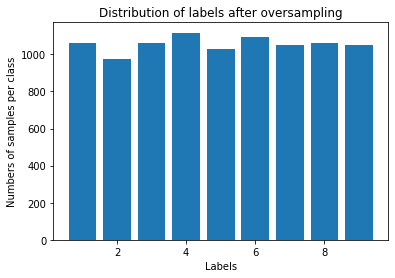

In [4]:
# Oversampling
x_train, y_train = ADASYN(sampling_strategy="auto").fit_sample(x_train, y_train)
print("Training Data Shape after Oversampling:", x_train.shape)
plt.title("Distribution of labels after oversampling")
plt.xlabel("Labels")
plt.ylabel("Numbers of samples per class")
plt.bar(
    np.unique(y_train, return_counts=True)[0], np.unique(y_train, return_counts=True)[1]
)

In [5]:
# new labels 0,1,...8
y_train = y_train - 1
y_test = y_test - 1 

## Training Models

In [6]:
# initialize model
model = CatBoostClassifier(
    iterations=250,
    learning_rate=0.01,
    depth=4,
    l2_leaf_reg=3,
    model_size_reg=10,
    rsm=None,
    loss_function="MultiClass", # Negative Log Likelihood Loss 
    random_seed=100,
    classes_count=9,
    verbose=False,
    bagging_temperature=1.0,
    boosting_type="Plain",  # Ordered — Usually provides better quality on small datasets, but it may be slower than the Plain scheme. Plain — The classic gradient boosting scheme.
    max_bin=255,
)

In [7]:
modeltime = datetime.datetime.now().strftime("%y-%m-%d-%H-%M-%S")

# train the model
model.fit(x_train, y_train, verbose_eval=0)

In [8]:
model.get_evals_result()

{'learn': {'MultiClass': [2.1891149689779703,
   2.1789091689873974,
   2.1701073710202015,
   2.1611275439980275,
   2.1513863171651852,
   2.142637482121324,
   2.135146522104353,
   2.1270162908750745,
   2.1184116825177175,
   2.1103188110326747,
   2.101577271980214,
   2.0931742833526803,
   2.085689736187198,
   2.078192815595903,
   2.0708107956493667,
   2.0640889748100584,
   2.0571448334204825,
   2.0503025595521964,
   2.0427695364905665,
   2.036134964600701,
   2.0304360736853933,
   2.0238674814586988,
   2.0180416454328696,
   2.012278384527866,
   2.0068260125632986,
   1.9992925672682023,
   1.9936534394096075,
   1.9885734617338187,
   1.982499242602474,
   1.9771868471469791,
   1.9714875316410791,
   1.9650608359421669,
   1.9599431709888817,
   1.9544596431457462,
   1.948972473408618,
   1.9433995001812892,
   1.937866140509766,
   1.932071987061004,
   1.9271118234489337,
   1.9222606315038937,
   1.9168725673805525,
   1.911957621644611,
   1.9071876523810944,


In [9]:
modeltime

'20-11-10-00-23-25'

In [10]:
model.save_model("models/catboost_" + "modeltime_" + modeltime)

In [11]:
# make the prediction using the resulting model
preds_class = model.predict(x_test)
preds_proba = model.predict_proba(x_test)
print("proba = ", preds_proba)

proba =  [[0.14443398 0.08775679 0.12988113 ... 0.07922435 0.04841243 0.08092841]
 [0.52478903 0.0599828  0.04063185 ... 0.0559959  0.0594105  0.05789805]
 [0.11150493 0.11748814 0.11369015 ... 0.14658918 0.11566962 0.04492339]
 ...
 [0.06290462 0.24920804 0.05921362 ... 0.24430496 0.05067408 0.0320001 ]
 [0.15028952 0.08124112 0.11042325 ... 0.08514706 0.0930819  0.11733668]
 [0.06985003 0.20424172 0.13375731 ... 0.21572644 0.06236112 0.042269  ]]


In [12]:
# Transform into submission format
submission = pd.DataFrame(preds_proba, columns=["class" + str(c + 1) for c in range(9)])
submission["ID"] = np.arange(1, 987)
# Save submission without weighting
submission.to_csv("submissions/submission_catboost_" + modeltime + ".csv", index=False)

## Weighting Predictions

In [13]:
all_1_over_9 = pd.read_csv(os.path.join(data_path, "external/submission_1_over_9.csv"))
all_1_over_9 = all_1_over_9.drop("ID", axis=1)

# weighted average
weighting = (6, 4)
submission_weighted = (preds_proba * weighting[0] + all_1_over_9 * weighting[1]) / 10
submission_weighted.shape

(986, 9)

## Private Leaderboard Evaluation

In [14]:
ids = pd.read_csv(os.path.join(data_path, "raw/stage_2_private_solution.csv")).ID.values
pred = np.take(submission_weighted, (list(ids - 1)), axis=0)
pred

,class1,class2,class3,class4,class5,class6,class7,class8,class9
7,0.140541,0.090284,0.116338,0.176322,0.100194,0.109569,0.087873,0.090156,0.088723
14,0.099591,0.122168,0.114507,0.105355,0.118495,0.118478,0.136853,0.113068,0.071483
15,0.168398,0.098539,0.096695,0.132461,0.095036,0.110847,0.088244,0.133278,0.076501
17,0.081170,0.179718,0.094425,0.101202,0.086818,0.084137,0.203637,0.094617,0.074275
18,0.084536,0.128339,0.093045,0.083801,0.101442,0.120338,0.187309,0.123458,0.077732
...,...,...,...,...,...,...,...,...,...
965,0.092286,0.152079,0.118949,0.108855,0.092866,0.102736,0.173563,0.087098,0.071568
970,0.168144,0.124615,0.092422,0.110812,0.087715,0.099499,0.098076,0.147257,0.071461
971,0.170631,0.105744,0.111841,0.167108,0.094613,0.100725,0.108603,0.073554,0.067182
972,0.162258,0.116480,0.087910,0.100554,0.082710,0.125377,0.098765,0.147827,0.078120


Accuracy: 0.144 Log loss: 2.060835392527957 F1 micro: 0.144 F1 macro: 0.05980330198508539


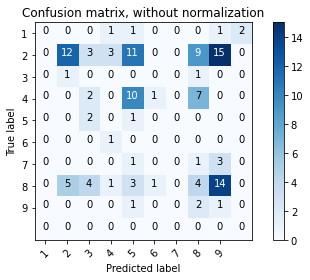

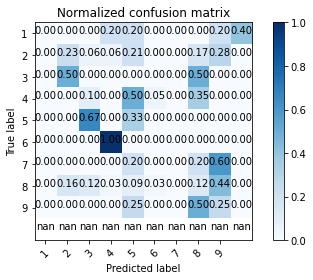

Evaluation data is added to results_catboost.csv


In [15]:
ev = Evaluation(y_pred=pred.to_numpy(), y_test=y_test)
ev.entire_evaluation(filename="results_catboost.csv")

## Save Submission

In [16]:
# transform weighted average into kaggle format
submission_weighted = pd.DataFrame(
    submission_weighted, columns=["class" + str(c + 1) for c in range(9)]
)
submission_weighted["ID"] = np.arange(1, 987)

# save submission
submission_weighted.to_csv(
    "submissions/submission_catboost_weighted"
    + str(weighting)
    + "_"
    + modeltime
    + ".csv",
    index=False,
)